In [1]:
import torch
import torch.nn as nn
import numpy as np
from dataloader import EHRDataset
from torch.utils.data import DataLoader
from models.transformer_model1 import TransformerPredictor
from models.SWE import SWE_Pooling
from utils import create_tokenizer, compute_metrics
from tqdm import trange, tqdm
import copy
import json

create_tokenizer()
train_dataset = EHRDataset(mode="train",sequence_length=100)
test_dataset = EHRDataset(mode="test",sequence_length=100)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

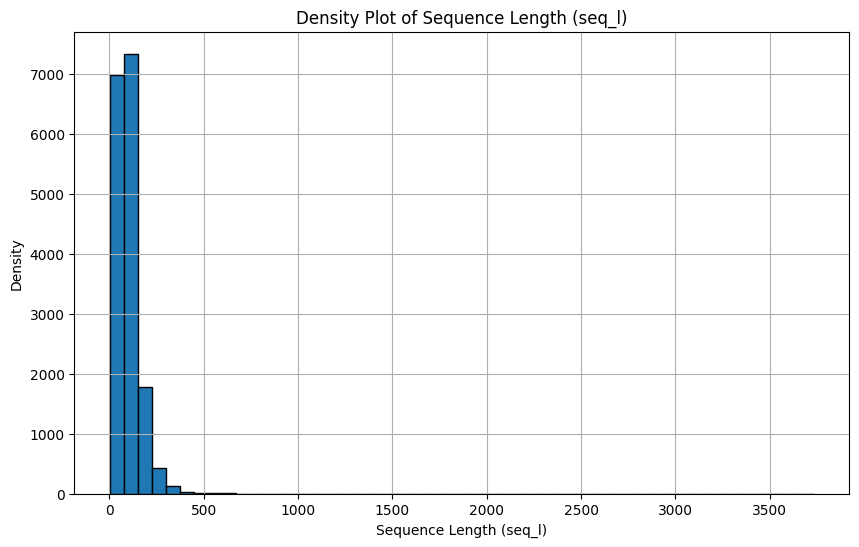

In [6]:
import json
path_documents = "events.json"

with open(path_documents) as f:
    data = json.load(f)

seq_lengths = []

for patient in data.values():
    t_list, v_list = list(map(float, patient.keys())), list(patient.values())
    seq_length = sum(len(v) for v in v_list)
    seq_lengths.append(seq_length)

plt.figure(figsize=(10, 6))
plt.hist(seq_lengths, bins=50, edgecolor='black')
plt.xlabel("Sequence Length (seq_l)")
plt.ylabel("Density")
plt.title("Density Plot of Sequence Length (seq_l)")
plt.grid(True)
plt.show()

In [3]:
from torch.utils.data import WeightedRandomSampler

targets = np.array(list(train_dataset.targets.values()))
labels_uniques, counts = np.unique(targets, return_counts=True)
class_weights = [sum(counts)/c for c in counts]
weights = [class_weights[x] for x in targets]


In [4]:
len(targets)

13407

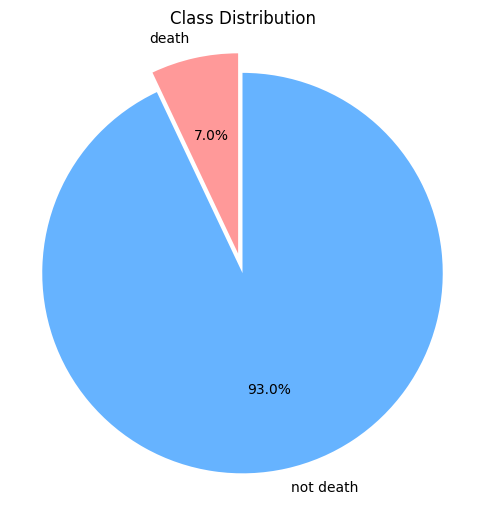

In [5]:
import matplotlib.pyplot as plt
labels = ['death', 'not death']  
colors = ['#ff9999', '#66b3ff']  

plt.figure(figsize=(6, 6))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, explode=(0.1, 0))
plt.title('Class Distribution')
plt.axis('equal')  
plt.show()

In [3]:
import torch
import torch.nn as nn
import numpy as np
from dataloader import EHRDataset
from torch.utils.data import DataLoader
from models.transformer_model import TransformerPredictor
from utils import create_tokenizer, compute_metrics
from tqdm import trange, tqdm
import copy

create_tokenizer()
train_dataset = EHRDataset(mode="train")
test_dataset = EHRDataset(mode="test")

device = 'cuda' if torch.cuda.is_available() else 'cpu'

from torch.utils.data import WeightedRandomSampler

targets = np.array(list(train_dataset.targets.values()))
labels_uniques, counts = np.unique(targets, return_counts=True)
class_weights = [sum(counts)/c for c in counts]
weights = [class_weights[x] for x in targets]
sampler = WeightedRandomSampler(weights, len(targets))

criterion = nn.BCELoss().to(device)

d_embed, d_transformer = 48, 128

model = TransformerPredictor(d_embedding=d_embed, d_model=d_transformer, n_layers=2, tokenizer_codes=train_dataset.tokenizer, dropout=0.5, device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=1
    # weight_decay=1e-4
    )

best_test_auprc = 0.
patience, current_patience = 15, 0

# Training loop
epochs = 100
start_lr, end_lr = 1e-4, 1e-5
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: start_lr*(1-epoch/epochs) + end_lr*(epoch/epochs))

for epoch in range(epochs):
    model.train()
    y_prob, y_true = [], []
    for e in DataLoader(dataset=train_dataset, batch_size=14000, drop_last=False, sampler=sampler):
        optimizer.zero_grad()
        
        minutes, codes, values = e['minutes'].to(device), e['codes'].to(device), e['values'].to(device)
        y = e['target'].to(device)

        output = model(codes, values, minutes)
        loss = criterion(output.squeeze(), y.float())
        loss.backward()
        optimizer.step()

        y_prob += output.squeeze().detach().tolist()
        y_true += y.tolist()
        
    acc, auprc, auroc, bce = compute_metrics(y_true, y_prob)
    print(f"Epoch {1+epoch}: train: acc {round(acc, 3)}; auprc {round(auprc, 3)}; auroc {round(auroc, 3)}; bce {round(bce, 3)}")
    scheduler.step()
    
    model.eval()
    y_prob, y_true = [], []
    for e in DataLoader(dataset=test_dataset, batch_size=14000, shuffle=False, drop_last=False):
        minutes, codes, values = e['minutes'].to(device), e['codes'].to(device), e['values'].to(device)
        y = e['target'].to(device)

        output = model(codes, values, minutes)
        loss = criterion(output.squeeze(), y.float())
        
        y_prob += output.squeeze().detach().tolist()
        y_true += y.tolist()

    acc, auprc, auroc, bce = compute_metrics(y_true, y_prob)
    print(f" test: acc {round(acc, 3)}; auprc {round(auprc, 3)}; auroc {round(auroc, 3)}; bce {round(bce, 3)}\n")
    if auprc > best_test_auprc:
        current_patience = 0
        best_test_auprc = auprc
        best_dict = copy.deepcopy(model.state_dict())
        best_row = f" best test (epoch {epoch}): acc {round(acc, 3)}; auprc {round(auprc, 3)}; auroc {round(auroc, 3)}; bce {round(bce, 3)}"
    else :
        current_patience += 1

    tqdm.write(best_row)
    
    if current_patience == patience:
        break
        



Epoch 1: train: acc 50.19; auprc 0.508; auroc 0.504; bce 0.722
 test: acc 14.238; auprc 0.105; auroc 0.597; bce 0.708

 best test (epoch 0): acc 14.238; auprc 0.105; auroc 0.597; bce 0.708
Epoch 2: train: acc 50.362; auprc 0.507; auroc 0.505; bce 0.72
 test: acc 12.356; auprc 0.103; auroc 0.591; bce 0.734

 best test (epoch 0): acc 14.238; auprc 0.105; auroc 0.597; bce 0.708
Epoch 3: train: acc 49.877; auprc 0.498; auroc 0.5; bce 0.719
 test: acc 12.508; auprc 0.099; auroc 0.587; bce 0.738

 best test (epoch 0): acc 14.238; auprc 0.105; auroc 0.597; bce 0.708
Epoch 4: train: acc 50.153; auprc 0.498; auroc 0.504; bce 0.718
 test: acc 13.752; auprc 0.099; auroc 0.586; bce 0.727

 best test (epoch 0): acc 14.238; auprc 0.105; auroc 0.597; bce 0.708
Epoch 5: train: acc 50.518; auprc 0.506; auroc 0.51; bce 0.714
 test: acc 18.306; auprc 0.097; auroc 0.585; bce 0.712

 best test (epoch 0): acc 14.238; auprc 0.105; auroc 0.597; bce 0.708
Epoch 6: train: acc 50.869; auprc 0.515; auroc 0.514; b

KeyboardInterrupt: 

In [5]:
def model_train(
    device = 'cuda' if torch.cuda.is_available() else 'cpu', 
    d_embed=48, 
    d_transformer=128, 
    start_lr=1e-4, 
    end_lr=1e-5, 
    n_layer=2, 
    dropout=0.5, 
    weight_decay=1e-4, 
    epochs=100, 
    patience=10,
    num_slices=256,
    num_ref_points=10,
    seq_l=100,
    pooling="cls" # cls mean mean_without_padding swe max
    
):
    sampler = WeightedRandomSampler(weights, len(targets))
    criterion = nn.BCELoss().to(device)
    train_dataset = EHRDataset(mode="train",sequence_length=seq_l)
    test_dataset = EHRDataset(mode="test",sequence_length=seq_l)
    if pooling == "swe":
        swe_pooling_layer= SWE_Pooling(d_in=d_transformer, num_slices=num_slices, num_ref_points=num_ref_points, freeze_swe=False).to(device)
    else:
        swe_pooling_layer=None
    model = TransformerPredictor(
        d_embedding=d_embed, 
        d_model=d_transformer, 
        n_layers=n_layer, 
        swe_pooling=swe_pooling_layer,
        tokenizer_codes=train_dataset.tokenizer, 
        dropout=dropout, 
        device=device,
        pooling=pooling
    ).to(device)
    if pooling == "swe":
        optimizer = torch.optim.Adam(
            list(model.swe_pooling.parameters()) + list(model.cls.parameters()) + list(model.transformer.parameters()),
            lr=1,
            #weight_decay=weight_decay
        )
    else:
        optimizer = torch.optim.Adam(
            model.parameters(),
            lr=1,
            #weight_decay=weight_decay
        )

    scheduler = torch.optim.lr_scheduler.LambdaLR(
        optimizer, 
        lr_lambda=lambda epoch: start_lr * (1 - epoch / epochs) + end_lr * (epoch / epochs)
    )

    best_test_auprc = 0.
    current_patience = 0

    for epoch in range(epochs):
        model.train()
        y_prob, y_true = [], []

        for e in DataLoader(dataset=train_dataset, batch_size=8192, drop_last=False, sampler=sampler):
            optimizer.zero_grad()
            attention_mask=e["attention_mask"].to(device)
            minutes, codes, values = e['minutes'].to(device), e['codes'].to(device), e['values'].to(device)
            y = e['target'].to(device)
    
            output = model(codes, values, minutes,attention_mask)
            loss = criterion(output.squeeze(), y.float())
            loss.backward()
            optimizer.step()
    
            y_prob += output.squeeze().detach().cpu().tolist()
            y_true += y.cpu().tolist()
        #for name, param in model.named_parameters():
        #    if param.requires_grad:
        #        print(f"{name} - mean: {param.data.mean()}")
        acc, auprc, auroc, bce = compute_metrics(y_true, y_prob)
        print(f"Epoch {epoch + 1}: train: acc {round(acc, 3)}; auprc {round(auprc, 3)}; auroc {round(auroc, 3)}; bce {round(bce, 3)}")
        scheduler.step()

        model.eval()
        y_prob, y_true = [], []
        #with torch.no_grad():
        for e in DataLoader(dataset=test_dataset, batch_size=8192, shuffle=False, drop_last=False):
            minutes, codes, values = e['minutes'].to(device), e['codes'].to(device), e['values'].to(device)
            y = e['target'].to(device)
            attention_mask=e["attention_mask"].to(device)
    
            output = model(codes, values, minutes, attention_mask)
            y_prob += output.squeeze().detach().cpu().tolist()
            y_true += y.cpu().tolist()
            
        acc, auprc, auroc, bce = compute_metrics(y_true, y_prob)
        print(f" Test: acc {round(acc, 3)}; auprc {round(auprc, 3)}; auroc {round(auroc, 3)}; bce {round(bce, 3)}")

        #
        if auprc > best_test_auprc:
            current_patience = 0
            best_test_auprc = auprc
            best_dict = copy.deepcopy(model.state_dict())
            best_row = f" best test (epoch {epoch}): acc {round(acc, 3)}; auprc {round(auprc, 3)}; auroc {round(auroc, 3)}; bce {round(bce, 3)}"
        else:
            current_patience += 1
        tqdm.write(best_row)
        if current_patience >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

In [7]:
def ensemble_model_train(
    device = 'cuda' if torch.cuda.is_available() else 'cpu', 
    d_embed=48, 
    d_transformer=128, 
    start_lr=1e-4, 
    end_lr=1e-5, 
    n_layer=2, 
    dropout=0.5, 
    weight_decay=1e-4, 
    epochs=100, 
    patience=10,
    num_slices=128,
    num_ref_points=30,
    seq_l=100,
    pooling="cls",  # One of "cls", "mean_without_padding", "swe", "max", etc.
    n_trainings=1,   # Number of models in the ensemble
    batch_size=14000,
    save_dir='model_ensemble_preds'
):
    """
    Train multiple models and predict probabilities on the test set, saving them in a DataFrame.

    Parameters
    ----------
    device : str
        The device to be used for training, defaults to 'cuda' if available, otherwise 'cpu'.
    d_embed, d_transformer, n_layer, dropout, etc. :
        Hyperparameters for the Transformer model. Adjust them to match your model definition.
    start_lr, end_lr : float
        Initial and final learning rates for the scheduler.
    weight_decay : float
        Weight decay (L2 regularization) for the optimizer.
    epochs : int
        Maximum number of training epochs.
    patience : int
        Early stopping patience. Training stops when the test AUPRC has not improved for `patience` consecutive epochs.
    seq_l : int
        Length of the EHR sequence.
    pooling : str
        Pooling method, e.g. "cls", "swe", "mean_without_padding", etc.
    n_trainings : int
        Number of models to train in the ensemble.
    batch_size : int
        Batch size for the DataLoader.
    save_dir : str
        Directory where the prediction results will be saved.

    Returns
    -------
    predictions_df : pandas.DataFrame
        A DataFrame with shape (n_test_samples, n_trainings). Each column contains probabilities for the test set
        predicted by one of the ensemble models.
    """

    # Build training and test datasets
    train_dataset = EHRDataset(mode="train", sequence_length=seq_l)
    test_dataset = EHRDataset(mode="test", sequence_length=seq_l)

    # Create a sampler for the training set, define the loss function, etc.
    sampler = WeightedRandomSampler(weights, len(targets),replacement=True)
    criterion = nn.BCELoss().to(device)

    # Prepare a DataFrame to store the predictions on the test set.
    # Each ensemble model will fill one column of this DataFrame.
    n_test_samples = len(test_dataset)
    predictions_df = pd.DataFrame(index=range(n_test_samples), columns=range(n_trainings))

    print(f"\nTraining {n_trainings} models for the ensemble...")

    for i in range(n_trainings):
        print(f"\n=== Ensemble Model {i+1}/{n_trainings} ===")

        # If we are using SWE pooling, initialize swe_pooling_layer
        if pooling == "swe":
            swe_pooling_layer = SWE_Pooling(
                d_in=d_transformer, 
                num_slices=num_slices, 
                num_ref_points=num_ref_points, 
                freeze_swe=False
            ).to(device)
        else:
            swe_pooling_layer = None

        # Initialize the model
        model = TransformerPredictor(
            d_embedding=d_embed, 
            d_model=d_transformer, 
            n_layers=n_layer, 
            swe_pooling=swe_pooling_layer,
            tokenizer_codes=train_dataset.tokenizer, 
            dropout=dropout, 
            device=device,
            pooling=pooling
        ).to(device)

        # Based on pooling method (with or without SWE), decide which parameters to update
        if pooling == "swe":
            optimizer = torch.optim.Adam(
                list(model.swe_pooling.parameters()) + 
                list(model.cls.parameters()) + 
                list(model.transformer.parameters()),
                lr=1,  # Will be changed by the scheduler later
                # weight_decay=weight_decay
            )
        else:
            optimizer = torch.optim.Adam(
                model.parameters(),
                lr=1,  # Will be changed by the scheduler later
                # weight_decay=weight_decay
            )

        # Define a LambdaLR for learning rate scheduling
        # This is a linear decay from start_lr to end_lr
        def lr_lambda_fun(epoch):
            if epochs > 1:
                ratio = 100-epoch / 100
            else:
                ratio = 1
            return start_lr * ratio + end_lr*(1-ratio)

        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda_fun)

        best_test_auprc = 0.0
        current_patience = 0
        best_model_dict = None
        best_info = ""  # to store info about the best performance

        # Start the training loop
        for epoch in range(epochs):
            model.train()
            y_prob_train, y_true_train = [], []

            dataloader_train = DataLoader(
                dataset=train_dataset, 
                batch_size=batch_size, 
                drop_last=False, 
                sampler=sampler
            )
            for e in dataloader_train:
                optimizer.zero_grad()
                attention_mask = e["attention_mask"].to(device)
                minutes = e["minutes"].to(device)
                codes = e["codes"].to(device)
                values = e["values"].to(device)
                y = e["target"].to(device)
        
                output = model(codes, values, minutes, attention_mask)
                loss = criterion(output.squeeze(), y.float())
                loss.backward()
                optimizer.step()
        
                y_prob_train += output.squeeze().detach().cpu().tolist()
                y_true_train += y.cpu().tolist()

            # Compute metrics for the training set
            acc, auprc, auroc, bce = compute_metrics(y_true_train, y_prob_train)
            #print(f"Epoch {epoch + 1}: train metrics -> "
            #      f"acc {round(acc, 3)}, auprc {round(auprc, 3)}, auroc {round(auroc, 3)}, bce {round(bce, 3)}")

            scheduler.step()

            # Evaluate on the test set
            model.eval()
            y_prob_test, y_true_test = [], []
            dataloader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

            with torch.no_grad():
                for e in dataloader_test:
                    attention_mask = e["attention_mask"].to(device)
                    minutes = e["minutes"].to(device)
                    codes = e["codes"].to(device)
                    values = e["values"].to(device)
                    y = e["target"].to(device)
            
                    output = model(codes, values, minutes, attention_mask)
                    y_prob_test += output.squeeze().detach().cpu().tolist()
                    y_true_test += y.cpu().tolist()

            # Compute metrics for the test set
            acc_test, auprc_test, auroc_test, bce_test = compute_metrics(y_true_test, y_prob_test)
           # print(f"         test metrics -> "
            #      f"acc {round(acc_test, 3)}, auprc {round(auprc_test, 3)}, auroc {round(auroc_test, 3)}, bce {round(bce_test, 3)}")

            # Early stopping logic
            if auprc_test > best_test_auprc:
                current_patience = 0
                best_test_auprc = auprc_test
                best_model_dict = copy.deepcopy(model.state_dict())
                best_info = (f"Best so far at epoch {epoch+1} | "
                             f"acc {round(acc_test, 3)}, auprc {round(auprc_test, 3)}, "
                             f"auroc {round(auroc_test, 3)}, bce {round(bce_test, 3)}")
            else:
                current_patience += 1

            print(f"         {best_info}")  # print current best info

            if current_patience >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break
        
        # After finishing training, load the best model weights
        if best_model_dict is not None:
            model.load_state_dict(best_model_dict)
        model.eval()

        # Use the best model to predict the test set probabilities, store them in predictions_df
        y_prob_test = []
        dataloader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
        with torch.no_grad():
            for e in dataloader_test:
                attention_mask = e["attention_mask"].to(device)
                minutes = e["minutes"].to(device)
                codes = e["codes"].to(device)
                values = e["values"].to(device)
                output = model(codes, values, minutes, attention_mask)
                y_prob_test.extend(output.squeeze().detach().cpu().tolist())

        # Make sure y_prob_test matches the test dataset order (DataLoader has no shuffle)
        predictions_df[i] = y_prob_test

    # After training all models, save the prediction DataFrame to a pickle file
    save_path = os.path.join(save_dir, f"ensemble_{pooling}_sql{seq_l}.pkl")
    with open(save_path, 'wb') as f:
        pickle.dump(predictions_df, f)

    print(f"\nEnsemble predictions saved to {save_path}")
    print(f"Shape of predictions_df: {predictions_df.shape}")
    print(f"Sample predictions:\n{predictions_df.head()}")

    return predictions_df


In [ ]:
import pandas as pd
import os
import pickle
seqls=[5,50,100]
poolings=['swe', 'cls', 'mean',"mean_without_padding"]
for seql in seqls:
    for pooling in poolings:
        ensemble_model_train(seq_l=seql,pooling=pooling,n_trainings=10,start_lr=1e-4)


Training 10 models for the ensemble...

=== Ensemble Model 1/10 ===
         Best so far at epoch 1 | acc 92.866, auprc 0.072, auroc 0.495, bce 0.641
         Best so far at epoch 1 | acc 92.866, auprc 0.072, auroc 0.495, bce 0.641
         Best so far at epoch 3 | acc 7.134, auprc 0.074, auroc 0.499, bce 0.759
         Best so far at epoch 3 | acc 7.134, auprc 0.074, auroc 0.499, bce 0.759
         Best so far at epoch 3 | acc 7.134, auprc 0.074, auroc 0.499, bce 0.759
         Best so far at epoch 3 | acc 7.134, auprc 0.074, auroc 0.499, bce 0.759
         Best so far at epoch 3 | acc 7.134, auprc 0.074, auroc 0.499, bce 0.759
         Best so far at epoch 3 | acc 7.134, auprc 0.074, auroc 0.499, bce 0.759
         Best so far at epoch 3 | acc 7.134, auprc 0.074, auroc 0.499, bce 0.759
         Best so far at epoch 3 | acc 7.134, auprc 0.074, auroc 0.499, bce 0.759
         Best so far at epoch 11 | acc 7.165, auprc 0.08, auroc 0.525, bce 0.761
         Best so far at epoch 11 | acc

In [108]:
poolings = ["swe", "cls", "mean"]
truncations = ["5","50", "100"]

res_set = []
for pooling in poolings:
    trun_res = []
    for seq_l in truncations:
        try:
            #EHR/real_data/mimic3/model_ensemble_preds/ensemble_cls_sql100.pkl
            with open(f'model_ensemble_preds/ensemble_{pooling}_sql{seq_l}.pkl', 'rb') as f:
                sub_res = pickle.load(f)
        except FileNotFoundError:
            print(f"File model_ensemble_preds/ensemble_{pooling}_sql{seq_l}.pkl not found. Skipping.")
            continue
        trun_res.append(sub_res)
    res_set.append(trun_res)


In [109]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import (roc_auc_score, roc_curve, precision_recall_curve, average_precision_score,
                             brier_score_loss)
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns

def compute_ece(y_true, y_prob, n_bins=10):
    y_true = np.array(y_true)
    y_prob = np.array(y_prob)
    bin_edges = np.linspace(0, 1, n_bins + 1)
    ece = 0.0
    for i in range(n_bins):
        bin_lower = bin_edges[i]
        bin_upper = bin_edges[i + 1]
        bin_mask = (y_prob > bin_lower) & (y_prob <= bin_upper)
        bin_count = np.sum(bin_mask)
        if bin_count > 0:
            bin_accuracy = np.mean(y_true[bin_mask] == 1)
            bin_confidence = np.mean(y_prob[bin_mask])
            ece += np.abs(bin_accuracy - bin_confidence) * (bin_count / len(y_true))
    return ece

def uncertainty_auroc(y, predictions, variance):
    y = np.array(y)
    predictions = np.array(predictions)
    variance = np.array(variance)
    correctness = (y == (predictions > 0.5))
    fprs, tprs, _ = roc_curve(correctness, -1 * variance)
    auc = roc_auc_score(correctness, -1 * variance)
    return tprs, fprs, auc

def calculate_ause(uncertainty, predictions, targets, metric='brier',
                   uncertainty_type='variance', bins=10, save_path=None, min_fraction=0.0,
                   max_fraction=0.9, ax=None, color='b', label='Sparsification Error'):
    """
    Calculate and plot AUSE (Area Under the Sparsification Error) curve.

    Parameters:
    - uncertainty (np.ndarray): Uncertainty measure (e.g., variance or confidence).
    - predictions (np.ndarray): Predicted probabilities.
    - targets (np.ndarray): Ground truth labels (0 or 1).
    - metric (str): Error metric ('brier', 'mae', 'ece', or 'auc').
    - uncertainty_type (str): Type of uncertainty ('variance' or 'confidence').
    - bins (int): Number of bins for ECE calculation, only used if metric='ece'.
    - save_path (str): If provided, save the figure to this path.
    - min_fraction (float): Minimum fraction of samples to remove.
    - max_fraction (float): Maximum fraction of samples to remove.
    - ax (matplotlib.axes.Axes): Axis on which to plot. If None, create a new figure.
    - color (str): Color of the plotted line.
    - label (str): Base label for the line in the plot legend.

    Returns:
    - ause_pred (float): Computed AUSE value.
    """

    if not (len(predictions) == len(targets) == len(uncertainty)):
        raise ValueError("predictions, targets, and uncertainty must have the same length.")

    if len(predictions) < 10:
        raise ValueError("Not enough predictions for sparsification.")

    # Define error functions
    def brier_score(preds, tgts):
        return np.mean((preds - tgts)**2)

    def mean_absolute_error(preds, tgts):
        return np.mean(np.abs(preds - tgts))

    def calculate_ece_metric(preds, tgts, n_bins=10):
        n = len(preds)
        if n == 0:
            return np.nan
        bin_edges = np.linspace(0., 1., n_bins + 1)
        bin_indices = np.digitize(preds, bin_edges, right=True) - 1
        ece = 0.0
        for i in range(n_bins):
            bin_mask = bin_indices == i
            bin_size = np.sum(bin_mask)
            if bin_size > 0:
                bin_confidence = np.mean(preds[bin_mask])
                bin_accuracy = np.mean(tgts[bin_mask])
                ece += (bin_size / n) * np.abs(bin_accuracy - bin_confidence)
        return ece

    def calculate_auc_metric(preds, tgts):
        if len(np.unique(tgts)) < 2:
            return np.nan
        return roc_auc_score(tgts, preds)

    # Select error function
    if metric == 'brier':
        error_function = brier_score
    elif metric == 'mae':
        error_function = mean_absolute_error
    elif metric == 'ece':
        error_function = lambda p, t: calculate_ece_metric(p, t, n_bins=bins)
    elif metric == 'auc':
        error_function = calculate_auc_metric
    else:
        raise ValueError("Unknown metric. Choose from 'brier', 'mae', 'ece', or 'auc'.")

    sorted_inds_uncertainty = np.argsort(uncertainty)
    if metric in ['brier', 'mae']:
        if metric == 'brier':
            true_errors = (predictions - targets)**2
        else:  # mae
            true_errors = np.abs(predictions - targets)
        sorted_inds_error = np.argsort(true_errors)
    else:
        sorted_inds_error = None

    # Initialize lists
    uncertainty_scores = []
    oracle_scores = []

    fractions = np.linspace(min_fraction, max_fraction, int((max_fraction - min_fraction)/0.01) + 1)
    num_samples = len(predictions)

    for fraction in fractions:
        num_keep = max(1, int((1.0 - fraction) * num_samples))
        inds_keep_uncertainty = sorted_inds_uncertainty[:num_keep]
        remaining_preds = predictions[inds_keep_uncertainty]
        remaining_targets = targets[inds_keep_uncertainty]
        try:
            uncertainty_error_score = error_function(remaining_preds, remaining_targets)
        except ValueError as e:
            print(f"Error calculating {metric} at fraction {fraction:.2f}: {e}")
            uncertainty_error_score = np.nan
        uncertainty_scores.append(uncertainty_error_score)

        if sorted_inds_error is not None:
            inds_keep_oracle = sorted_inds_error[:num_keep]
            oracle_preds = predictions[inds_keep_oracle]
            oracle_targets = targets[inds_keep_oracle]
            try:
                oracle_error_score = error_function(oracle_preds, oracle_targets)
            except ValueError as e:
                print(f"Error calculating Oracle {metric} at fraction {fraction:.2f}: {e}")
                oracle_error_score = np.nan
            oracle_scores.append(oracle_error_score)
        else:
            oracle_scores.append(np.nan)

    uncertainty_scores = np.array(uncertainty_scores)
    oracle_scores = np.array(oracle_scores)

    # Normalize error scores
    if metric in ['brier', 'mae']:
        uncertainty_scores_normalized = uncertainty_scores / uncertainty_scores[0]
        if sorted_inds_error is not None:
            oracle_scores_normalized = oracle_scores / oracle_scores[0]
        else:
            oracle_scores_normalized = np.full_like(uncertainty_scores_normalized, np.nan)
    elif metric == 'ece':
        uncertainty_scores_normalized = uncertainty_scores / uncertainty_scores[0]
        oracle_scores_normalized = np.full_like(uncertainty_scores_normalized, np.nan)
    elif metric == 'auc':
        uncertainty_scores_normalized = (1 - uncertainty_scores) / (1 - uncertainty_scores[0])
        oracle_scores_normalized = np.full_like(uncertainty_scores_normalized, np.nan)
    else:
        raise ValueError("Unknown metric.")

    ause_pred = np.trapz(y=uncertainty_scores_normalized, x=fractions) / (max_fraction - min_fraction)

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    if metric in ['brier', 'mae', 'ece', 'auc']:
        # Include the AUSE value in the label
        ax.plot(fractions, uncertainty_scores_normalized, label=f"{label} (AUSE={ause_pred:.4f})", color=color)

    ax.set_xlabel("Fraction of removed samples")
    ax.set_ylabel(f"{metric.upper()} Error (Normalized)")
    ax.set_ylim([0, 1.5])
    ax.set_title('Sparsification Curve')
    ax.legend()
    ax.grid(True)

    if save_path:
        plt.savefig(save_path)
    elif ax is None:
        plt.show()

    return ause_pred

In [110]:
from sklearn.calibration import calibration_curve

In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,  # <-- IMPORT precision_recall_curve
)
from sklearn.calibration import calibration_curve
from scipy.stats import norm
import matplotlib

# Set English font (you can set to default or another English font if preferred)
# matplotlib.rcParams['font.family'] = 'Arial'  # Optional: Uncomment if you want to set to Arial
matplotlib.rcParams['axes.unicode_minus'] = False  # Solve the problem of minus sign display

def compute_ece(y_true, y_prob, n_bins=10):
    """
    Calculate Expected Calibration Error (ECE)
    """
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins)
    ece = np.abs(prob_true - prob_pred).mean()
    return ece

def shannon_entropy(p, epsilon=1e-10):
    """
    Calculate Shannon Entropy

    Parameters:
    - p: Probability of being the positive class (array)
    - epsilon: Small constant to prevent log(0)

    Returns:
    - entropy: Shannon entropy values (array)
    """
    p = np.clip(p, epsilon, 1 - epsilon)  # Prevent log(0)
    entropy = -p * np.log(p) - (1 - p) * np.log(1 - p)
    return entropy

# ---------------------------------------------------------------------
# Assume these 2 helper functions are defined somewhere:
#
# 1) calculate_ause(...)
# 2) uncertainty_auroc(...)
#
# (For brevity, you only need to ensure they exist and return the 
# expected output used in model_result_show)
# ---------------------------------------------------------------------

def model_result_show(prob_df_set, y, df_names, truncation_labels, truncation_colors, metric='brier'):
    """
    Visualize Results:
     - Column 1: Variance Density
     - Column 2: Uncertainty ROC
     - Column 3: Calibration Curve and ECE
     - Column 4: Standard ROC
     - Column 5: Sparsification Curve (with AUSE label)
     - Column 6: Brier Score Density Plot
     - Column 7: Prediction Distribution Entropy Density Plot
     - Column 8: NLL Density Plot
     - Column 9: Predicted Probability Density Plot
     - Column 10: **NEW** PR Curve (Precision-Recall)

    Parameters:
    - prob_df_set: Nested list [num_poolings][num_truncations], each element is the data for that truncation.
    - y: True labels
    - df_names: List of pooling method names
    - truncation_labels: List of truncation names
    - truncation_colors: List of truncation colors
    - metric: Metric for AUSE ('brier', 'mae', 'ece', 'auc')

    Returns:
    - metrics_df: DataFrame containing calculated metrics for each pooling and truncation.
    """
    y = np.array(y).ravel()
    num_poolings = len(prob_df_set)
    num_truncations = len(truncation_labels)

    # Create subplot layout (10 subplots for each pooling method, adding PR curve)
    fig, axes = plt.subplots(num_poolings, 10, figsize=(60, 6 * num_poolings))
    if num_poolings == 1:
        axes = np.array([axes])

    metrics_records = []
    colors = truncation_colors  # Use the provided color list

    for i in range(num_poolings):
        pooling_name = df_names[i]
        # Expand to 10 axes now
        ax_var_density        = axes[i][0]
        ax_unc_roc           = axes[i][1]
        ax_calibration       = axes[i][2]
        ax_normal_roc        = axes[i][3]
        ax_sparsification    = axes[i][4]
        ax_brier_density     = axes[i][5]
        ax_entropy_density   = axes[i][6]
        ax_nll_density       = axes[i][7]
        ax_pred_prob_density = axes[i][8]
        ax_pr                = axes[i][9]  # NEW: Precision-Recall curve axis

        for t_idx in range(num_truncations):
            df = prob_df_set[i][t_idx]
            df = np.array(df)
            trunc_name = truncation_labels[t_idx]

            # Calculate prediction mean and variance
            predictions = np.mean(df, axis=1)
            variance = np.var(df, axis=1)
            std_dev = np.sqrt(variance)

            # Calculate ROC and AUC
            normal_fpr, normal_tpr, _ = roc_curve(y, predictions)
            normal_auc = roc_auc_score(y, predictions)

            # Calculate Uncertainty ROC and AUC
            # (Assumes you have a function uncertainty_auroc)
            unc_tpr, unc_fpr, unc_auc = uncertainty_auroc(y, predictions, variance)

            # Calculate Calibration Curve and ECE
            prob_true, prob_pred = calibration_curve(y, predictions, n_bins=10)
            ece_score = compute_ece(y, predictions)

            # Calculate other metrics
            auprc = average_precision_score(y, predictions)
            # Brier Score for each sample
            brier = (y - predictions) ** 2
            # Calculate NLL (assuming binary classification predictions)
            epsilon = 1e-10  # Prevent log(0)
            nll = - y * np.log(predictions + epsilon) - (1 - y) * np.log(1 - predictions + epsilon)

            # Calculate Shannon Entropy
            entropy_pred = shannon_entropy(predictions)

            # Calculate Residual Variance (residual for each sample)
            residuals = y - predictions
            residual_var = residuals ** 2  # Residual variance for each sample

            # Calculate Predicted Probability Mean (Optional Metric)
            pred_prob_mean = np.mean(predictions)

            # -------- Plots --------
            c = colors[t_idx]
            variance_1 = np.round(np.mean(variance), 5)

            # 1) Variance Density Plot
            sns.kdeplot(
                variance,
                ax=ax_var_density,
                label=f"{trunc_name} (avg_Var={variance_1})",
                fill=False,
                color=c
            )

            # 2) Uncertainty ROC
            ax_unc_roc.plot(
                unc_fpr,
                unc_tpr,
                label=f"{trunc_name} (AUROC={unc_auc:.2f})",
                color=c
            )

            # 3) Calibration Curve
            ax_calibration.plot(
                prob_pred,
                prob_true,
                marker="o",
                label=f"{trunc_name} (ECE={ece_score:.2f})",
                color=c
            )

            # 4) Standard ROC
            ax_normal_roc.plot(
                normal_fpr,
                normal_tpr,
                label=f"{trunc_name} (AUC={normal_auc:.2f})",
                color=c
            )

            # 5) Sparsification Curve
            ause = calculate_ause(
                uncertainty=variance,
                predictions=predictions,
                targets=y,
                metric=metric,
                min_fraction=0.0,
                max_fraction=0.9,
                ax=ax_sparsification,
                color=c,
                label=f"{trunc_name}"
            )

            # 6) Brier Score Density Plot
            sns.kdeplot(
                brier,
                ax=ax_brier_density,
                label=f"{trunc_name} (Mean Brier={np.mean(brier):.4f})",
                color=c
            )

            # 7) Prediction Distribution Entropy Density Plot
            sns.kdeplot(
                entropy_pred,
                ax=ax_entropy_density,
                label=f"{trunc_name} (Mean Entropy={np.mean(entropy_pred):.4f})",
                color=c
            )

            # 8) NLL Density Plot
            sns.kdeplot(
                nll,
                ax=ax_nll_density,
                label=f"{trunc_name} (Mean NLL={np.mean(nll):.4f})",
                color=c
            )

            # 9) Predicted Probability Density Plot
            sns.kdeplot(
                predictions,
                ax=ax_pred_prob_density,
                label=f"{trunc_name} (Mean Pred={pred_prob_mean:.4f})",
                color=c
            )

            # 10) Precision-Recall Curve
            precision, recall, thresholds  = precision_recall_curve(y, predictions)
            auprc = average_precision_score(y, predictions)
            ax_pr.plot(
                recall,
                precision,
                marker='.',
                label=f"{trunc_name} (AUPRC={auprc:.2f})",
                color=c
            )
            
            ax_pr.set_xlim([0.0, 1.0])
            ax_pr.set_ylim([0.0, 1.05])
            ax_pr.set_xlabel('Recall')
            ax_pr.set_ylabel('Precision')
            ax_pr.set_title('Precision-Recall Curve')
            ax_pr.legend()
            ax_pr.grid(True)
            # Store metrics
            metrics_records.append({
                "pooling": pooling_name,
                "truncation": trunc_name,
                "normal_auc": normal_auc,
                "uncertainty_auc": unc_auc,
                "auprc": auprc,
                "ece": ece_score,
                "brier_score_mean": np.mean(brier),
                "entropy_mean": np.mean(entropy_pred),
                "nll_mean": np.mean(nll),
                "pred_prob_mean": pred_prob_mean,
                "ause": ause
            })

        # ----- Format each subplot -----
        ax_var_density.set_title(f"{pooling_name} Variance Density")
        ax_var_density.set_xlabel("Variance")
        ax_var_density.legend()

        ax_unc_roc.set_title(f"{pooling_name} Uncertainty ROC")
        ax_unc_roc.set_xlabel("False Positive Rate")
        ax_unc_roc.set_ylabel("True Positive Rate")
        ax_unc_roc.plot([0, 1], [0, 1], '--', color='gray')
        ax_unc_roc.legend()
        ax_unc_roc.grid(True)

        ax_calibration.set_title(f"{pooling_name} Calibration Curve")
        ax_calibration.set_xlabel("Mean Predicted Probability")
        ax_calibration.set_ylabel("Actual Positive Proportion")
        ax_calibration.plot([0, 1], [0, 1], linestyle="--", color="gray")
        ax_calibration.legend()

        ax_normal_roc.set_title(f"{pooling_name} ROC Curve")
        ax_normal_roc.set_xlabel("False Positive Rate")
        ax_normal_roc.set_ylabel("True Positive Rate")
        ax_normal_roc.plot([0, 1], [0, 1], '--', color="gray")
        ax_normal_roc.legend()
        ax_normal_roc.grid(True)

        ax_sparsification.set_title(f"{pooling_name} Sparsification Curve (Metric: {metric.upper()})")
        ax_sparsification.set_ylim([-0.01, 1.05])
        ax_sparsification.legend()
        ax_sparsification.grid(True)

        ax_brier_density.set_title(f"{pooling_name} Brier Score Density Plot")
        ax_brier_density.set_xlabel("Brier Score")
        ax_brier_density.set_ylabel("Density")
        ax_brier_density.legend()

        ax_entropy_density.set_title(f"{pooling_name} Prediction Distribution Entropy Density Plot")
        ax_entropy_density.set_xlabel("Entropy")
        ax_entropy_density.set_ylabel("Density")
        ax_entropy_density.legend()

        ax_nll_density.set_title(f"{pooling_name} Negative Log-Likelihood (NLL) Density Plot")
        ax_nll_density.set_xlabel("NLL")
        ax_nll_density.set_ylabel("Density")
        ax_nll_density.legend()

        ax_pred_prob_density.set_title(f"{pooling_name} Predicted Probability Density Plot")
        ax_pred_prob_density.set_xlabel("Predicted Probability")
        ax_pred_prob_density.set_ylabel("Density")
        ax_pred_prob_density.legend()

        # NEW: Precision-Recall subplot formatting
        ax_pr.set_title(f"{pooling_name} Precision-Recall Curve")
        ax_pr.set_xlabel("Recall")
        ax_pr.set_ylabel("Precision")
        ax_pr.legend()
        ax_pr.grid(True)

    plt.tight_layout()
    plt.show()

    return pd.DataFrame(metrics_records)


In [112]:
import seaborn as sns

In [123]:
test_dataset = EHRDataset(mode="test")
y_val_int = 1-np.array(list(test_dataset.targets.values()))

In [124]:
sum(y_val_int)

np.int64(126)

/tmp/ipykernel_308316/2474444826.py:166: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  ause_pred = np.trapz(y=uncertainty_scores_normalized, x=fractions) / (max_fraction - min_fraction)
/tmp/ipykernel_308316/2474444826.py:166: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  ause_pred = np.trapz(y=uncertainty_scores_normalized, x=fractions) / (max_fraction - min_fraction)
/tmp/ipykernel_308316/2474444826.py:166: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  ause_pred = np.trapz(y=uncertainty_scores_normalized, x=fractions) / (max_fraction - min_fraction)
/tmp/ipykernel_308316/2474444826.py:166: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.i

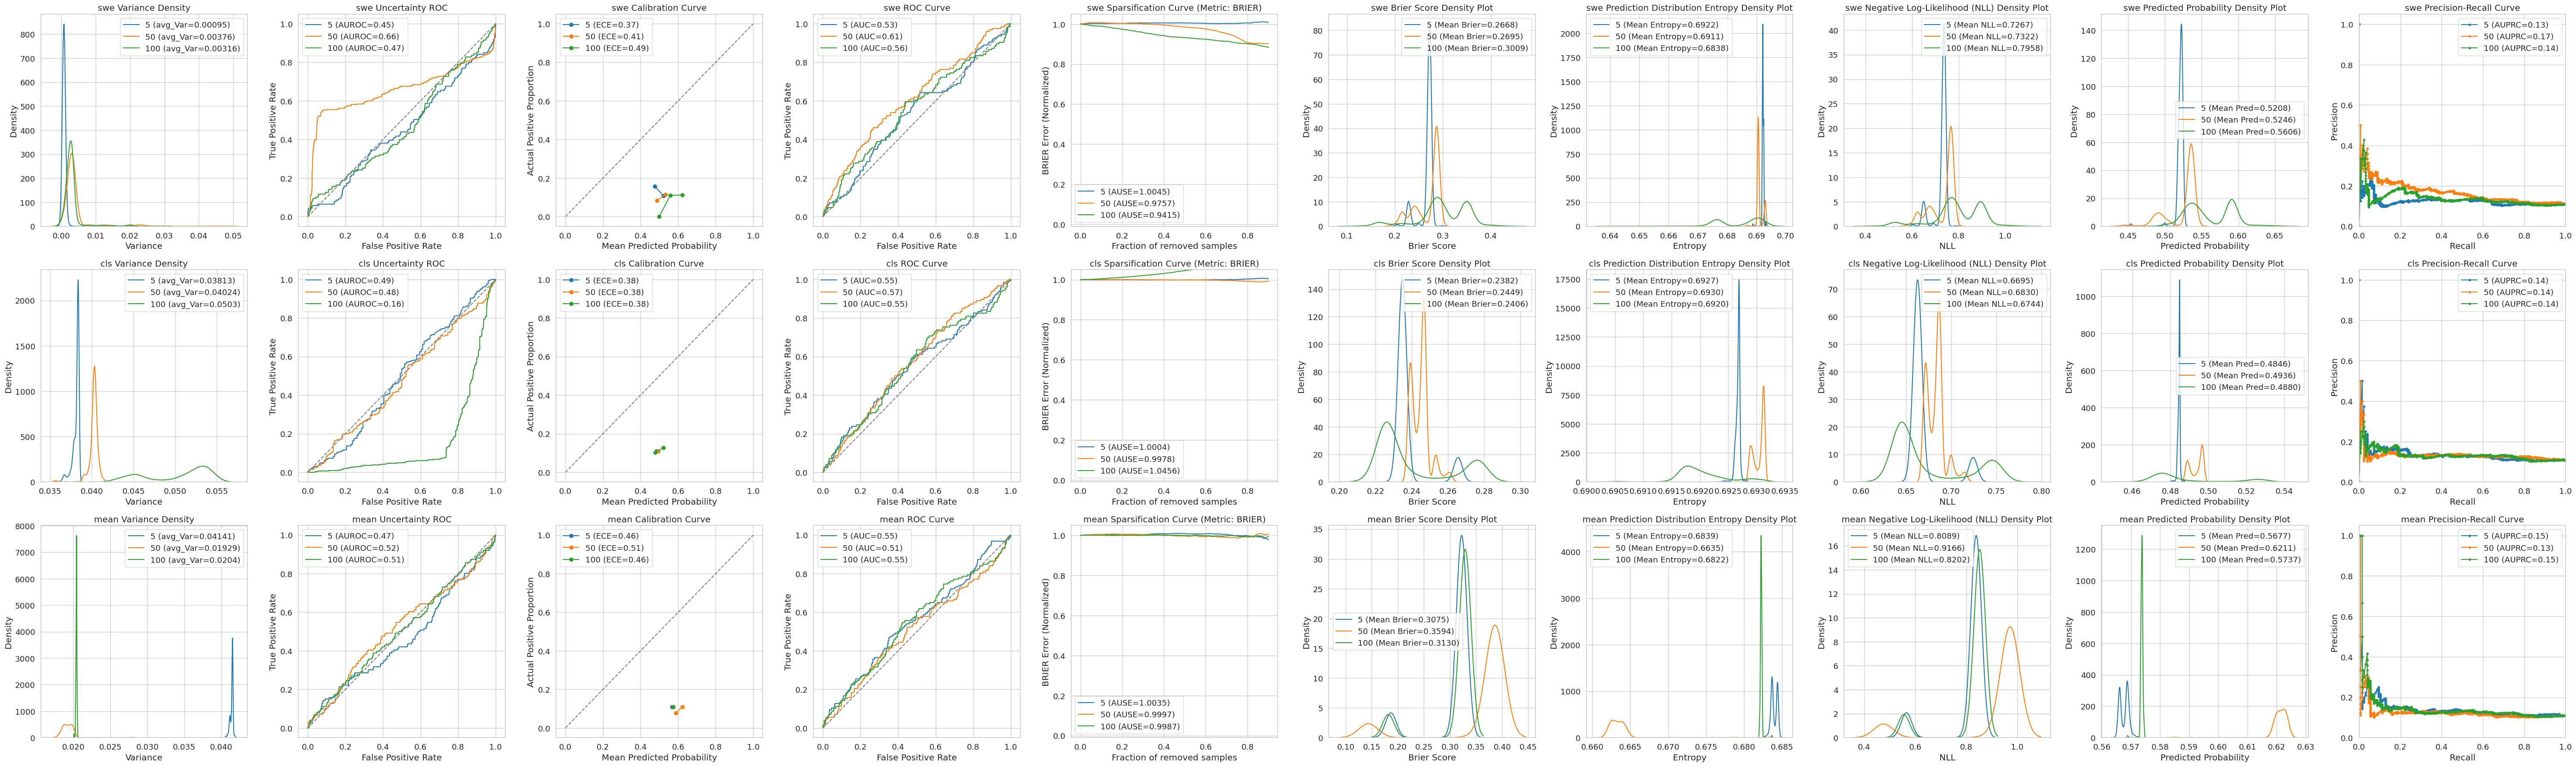

In [127]:
truncation_colors= sns.color_palette("tab10", n_colors=len(truncations))
data=model_result_show(res_set,y_val_int,poolings,truncations,truncation_colors,metric="brier")

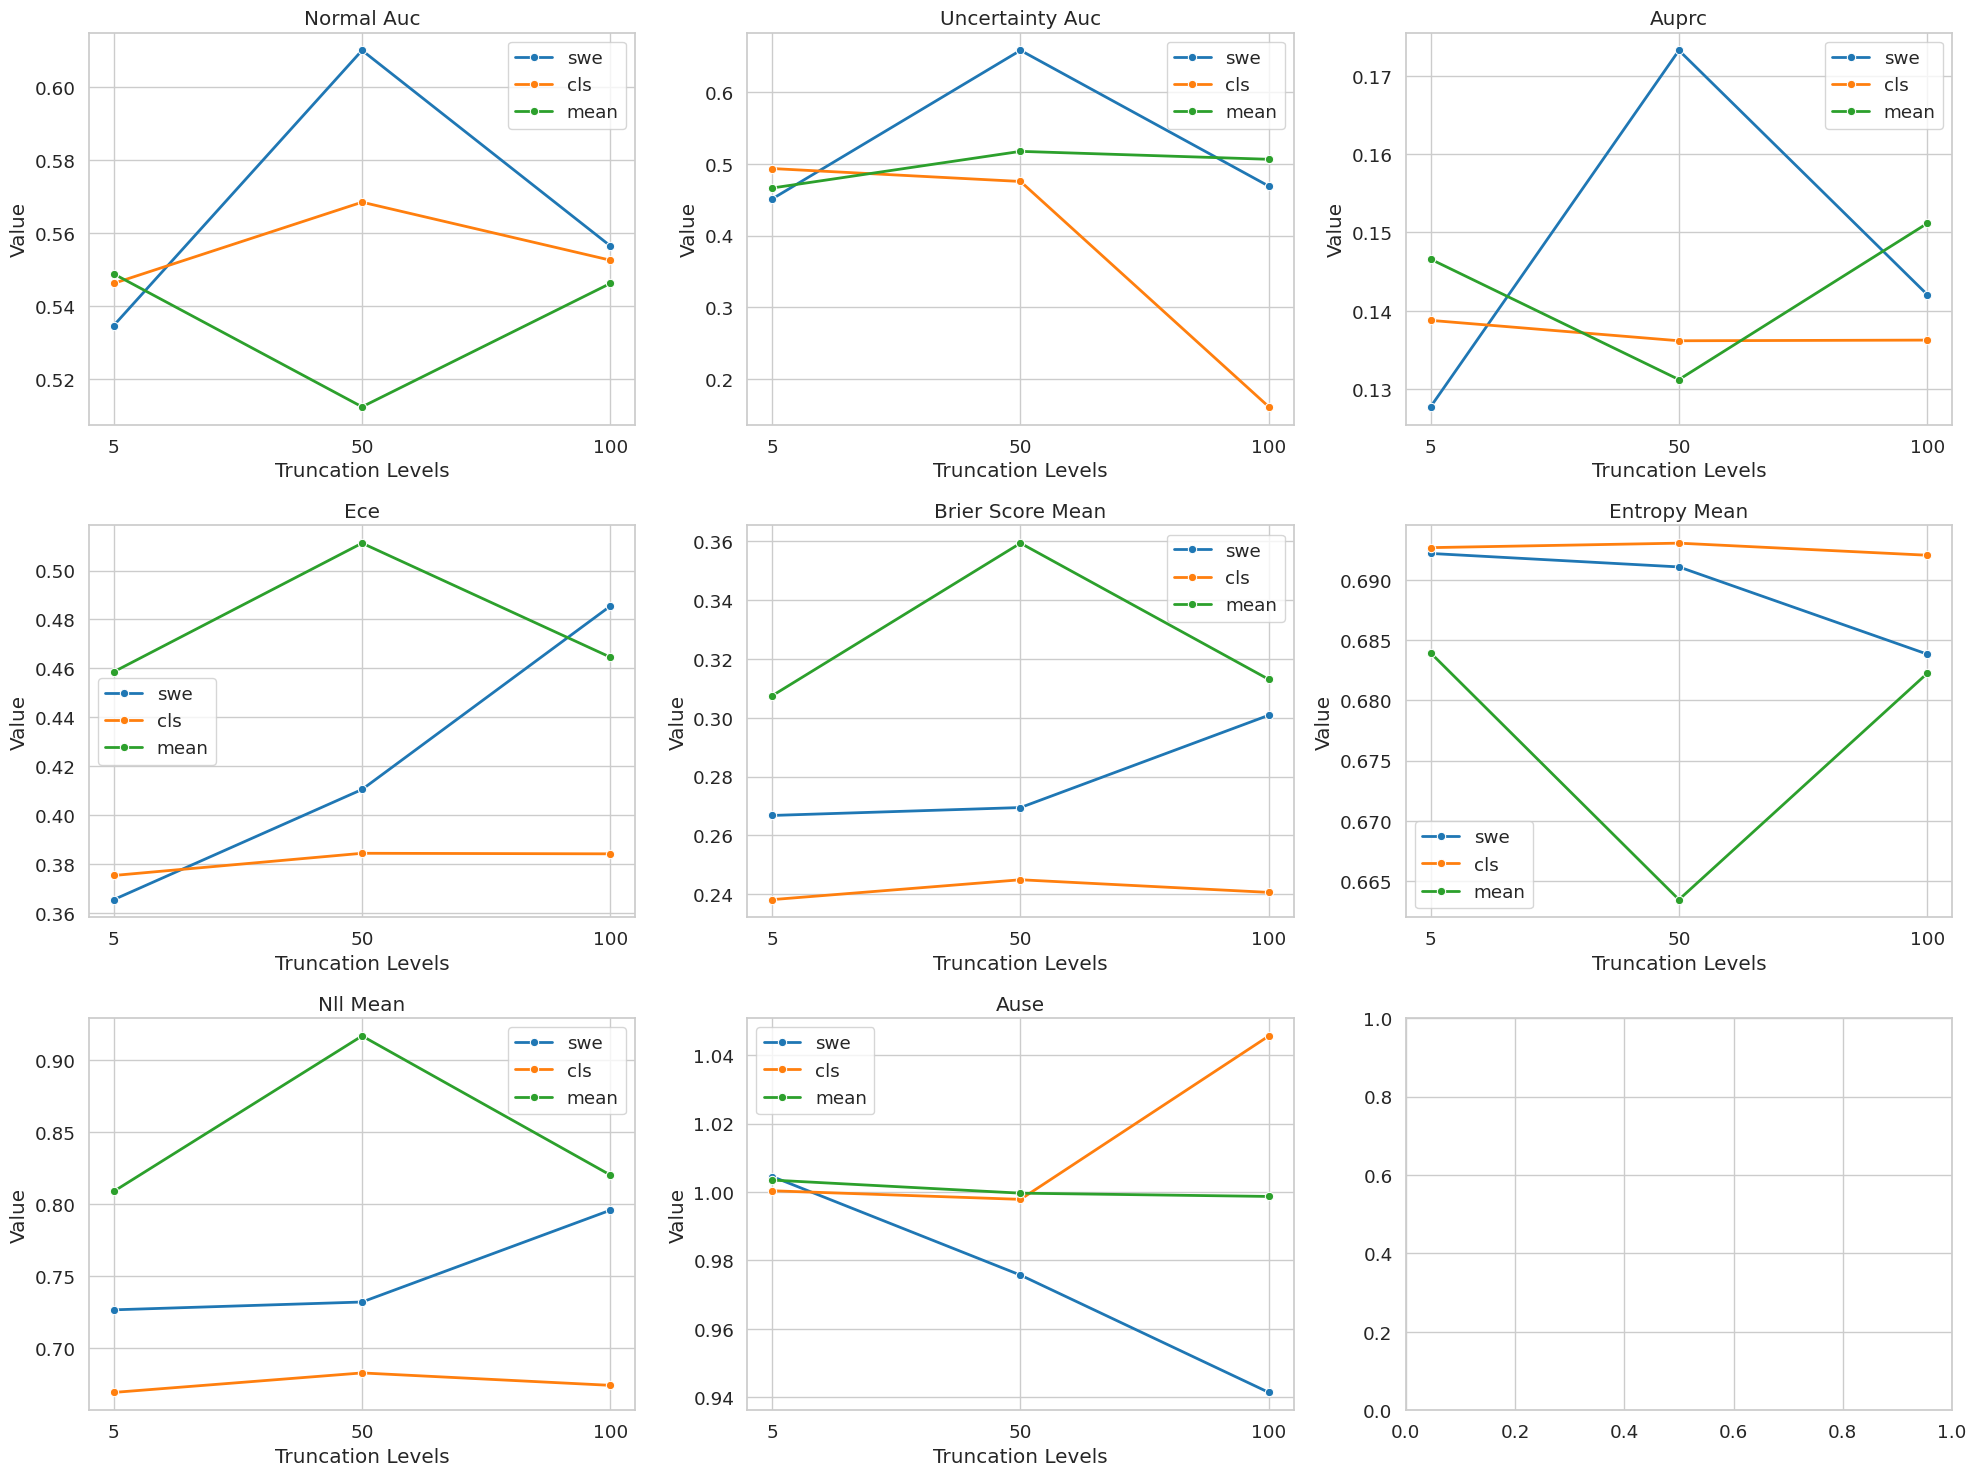

In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Create the DataFrame
# Assume 'data' is your original data already loaded
df = pd.DataFrame(data)

# Step 2: Ensure 'truncation' is treated as a categorical variable with a specified order
truncation_order = ["5", "50", "100"]
df['truncation'] = pd.Categorical(df['truncation'], categories=truncation_order, ordered=True)

# Step 3: Melt the DataFrame
metrics = ['normal_auc', 'uncertainty_auc', 'auprc', 'ece',
           'brier_score_mean', 'entropy_mean', 'nll_mean',
            'ause']

df_melted = df.melt(id_vars=['pooling', 'truncation'],
                    value_vars=metrics,
                    var_name='metric',
                    value_name='value')

# Step 4: Create Comparative Line Plots
sns.set(style="whitegrid", font_scale=1.2)

unique_metrics = df_melted['metric'].unique()
unique_poolings = df_melted['pooling'].unique()

# Create a color palette and map each pooling method to a color
palette = sns.color_palette("tab10", n_colors=len(unique_poolings))
color_dict = dict(zip(unique_poolings, palette))

num_metrics = len(unique_metrics)
num_cols = 3
num_rows = int(np.ceil(num_metrics / num_cols))

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
axes = axes.flatten()

# Step 5: Loop through each metric and plot
for idx, metric in enumerate(unique_metrics):
    ax = axes[idx]
    
    # Filter data for the current metric
    data_metric = df_melted[df_melted['metric'] == metric]
    
    # Plot each pooling method
    for pooling in unique_poolings:
        data_pooling = data_metric[data_metric['pooling'] == pooling]
        
        # Plot data with truncation as categorical variable
        sns.lineplot(data=data_pooling, x='truncation', y='value',
                     marker='o', label=pooling, color=color_dict[pooling], ax=ax, linewidth=2)
    
    # Set plot title and labels
    ax.set_title(metric.replace('_', ' ').title())  # Format the title
    ax.set_xlabel('Truncation Levels')  # x-axis label
    ax.set_ylabel('Value')  # y-axis label
    
    # Show legend
    ax.legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()
